---
## &nbsp;&nbsp;2η Άσκηση  -  Τεχνικές Εξόρυξης Δεδομένων - Εαρινό Εξάμηνο 2020-2021

* Φαραώ Γεώργιος&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- &nbsp;&nbsp;sdi1700177
* Ροβιθάκης Ιωάννης &nbsp; -&nbsp;&nbsp; sdi1800164
---

# Σημειώσεις - Παραδοχές

- 1) Παρατηρήσαμε ότι στις περισσότερες περιπτώσεις, το f1 score αποτέλεσμα της συνάρτησης f1_score(), έβγαινε πάντα το ίδιο με το accuracy της accuracy_score(). Ετσι, δοκιμάσαμε να υπολογίσουμε το f1 score με βάση τον αναλυτικό τύπο του ορισμού του (Τύπος από την wikipedia), γεγονός που μας έδωσε πιο λογικά αποτελέσματα οπότε και το κρατήσαμε έτσι

- 2) Επειδή θέλαμε να έχουμε μεγαλύτερη ευελιξία στις δοκιμές μας με τους διάφορους classifiers, αποφασίσαμε να μην χρησιμοποιήσουμε τα train και test datasets που δημιουργούμε στο ερώτημα 3 του πρώτου μέρους. Αντί αυτού, δημιουργούμε ένα πίνακα με τα δεδομένα μας "έτοιμα" σε διάφορα στάδια προεπεξεργασίας (πχ με stopwords, χωρις stopwords, με lemmatization κλπ) και στη συνέχεια παίρνουμε τα train και test datasets από αυτόν. Στόχος μας είναι να μπορούμε εύκολα και γρήγορα να βλέπουμε πειραματικά την επιρροή του κάθε σταδίου προεπεξεργασίας στα τελικά μας αποτελέσματα. 

- 3) Θεωρούμε ότι έχουμε καλύψει επαρκώς τον κώδικα μας σε σχόλια και εξηγήσεις. Για οποιαδήποτε περεταίρω απορία, διευκρίνηση ή παρατήρηση πάνω στην εργασία μας, μην διστάσετε να μας στείλετε ενα email στο sdi1800164@di.uoa.gr ή στο sdi1700177@di.uoa.gr

# Preparations

In [1]:
# Mount the google drive to have access to the files
from google.colab import drive
drive.mount('/content/gdrive')

# Import some of the libraries we will need
import re
import sys
import time
import math
import nltk
import heapq
import pickle
import os.path
import datetime
import numpy as np
import unicodedata
import pandas as pd
import multiprocessing
from nltk.stem import *
from sklearn import svm
from numpy import random
from scipy import sparse
from sklearn.svm import NuSVC
from string import punctuation
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from scipy.sparse import csr_matrix
from collections import OrderedDict
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
import matplotlib.patches as mpatches
from nltk.tokenize import word_tokenize
from sklearn.metrics import jaccard_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud, STOPWORDS
from scipy.spatial.distance import hamming
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from nltk.stem.snowball import SnowballStemmer
from gensim.parsing.porter import PorterStemmer
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
nltk.download('punkt')
nltk.download('stopwords')
%matplotlib inline 

Mounted at /content/gdrive
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Read the input files and create dataframes

# Location1 = r'/content/gdrive/MyDrive/TEDE/True.csv'
# Location2 = r'/content/gdrive/MyDrive/TEDE/Fake.csv'
Location1 = r'/content/gdrive/MyDrive/DataMining2021/TEDE_SHARED/True.csv'
Location2 = r'/content/gdrive/MyDrive/DataMining2021/TEDE_SHARED/Fake.csv'

true_df = pd.read_csv(Location1)
fake_df = pd.read_csv(Location2)
fake_df.head(1)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"


Ξεκινάμε ελέγχοντας αν υπάρχουν κενά στα δεδομένα μας:

In [3]:
data = [true_df, fake_df]
for df in data:
  print(df['title'].isnull().unique())
  print(df['text'].isnull().unique())
  print(df['subject'].isnull().unique())
  print(df['date'].isnull().unique())

[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]


Δεν φαίνεται να υπάρχουν κενές τιμές στα δεδομένα μας οπότε συνεχίζουμε κανονικά

Στις προβλέψεις μας, λαμβάνουμε υπόψιν μας μόνο τον τίτλο και το κείμενο. Αποφασίσαμε να το κανουμε έτσι διοτι με τις μεθόδους που χρησιμοποιούμε στα δεδομένα μας, θεωρούμε ότι οι πληροφορίες των στηλών 'subject' και 'date' δεν προσφέρουν κάποια χρήσιμη πληροφορία. Πχ ισως έχει σημασια η ημερομηνια σε σχέση με άλλα δεδομενα (πχ χρονολογικά cross checks για καλύτερη αξιοπιστία), αλλά για τις πολύ "απλές" μεθόδους με τις οποίες δουλεύουμε, και από τον τρόπο που λειτουργούν, αποφασίσαμε να τα παραλείψουμε σε αυτό το στάδιο

In [4]:
# The stopword "database"
stop_words = set(stopwords.words('english'))

# Returns a list containing the amounts of chars in the given column of the df
def getColumnLen(df, col):
  lenlist = []
  for index, row in df.iterrows():
    lenlist.append( len( str(row[col]) ) )
  return lenlist

# Returns the quotient of title and text lengths as a metric (explanation on part 3 of the assignment)
def getColMetrics(df):
  titlecounts = getColumnLen(df, 'title')
  textcounts  = getColumnLen(df, 'text')

  metric = []
  for i in range(len(titlecounts)):
    metric.append( (textcounts[i]/titlecounts[i])/(textcounts[i]+titlecounts[i]) )
  return (titlecounts, textcounts, metric)

# Returns the amount of special chars in the given string
def countSpec(txt):
  puncts = set(punctuation)
  count=0
  for ch in txt:
    if ch in puncts:
      count+=1
  return count

# Get a list containing the amount of special chars in both the title and the content of the articles
def getSpecial(df):
  speciaList = []
  for index, row in df.iterrows():
    txt = str(row['title']) + ' ' + str(row['text'])
    speciaList.append( countSpec(txt) )
  return speciaList

# Returns a list that contains all the words of each dataframe record in a srting
def getRecStrList(df):
  trainList = []
  for index, row in df.iterrows():
    txt = str(row['title']) + ' ' + str(row['text'])
    trainList.append(txt)
  return trainList

# Removes the stopwords from a string
def remove_stopwords(text):
  words = nltk.sent_tokenize(text)
  if len(words)==0:
    return ''
  temp_list= words[0].split()
  filtered = [w for w in temp_list if not w in stop_words]
  words[0]=" ".join(filtered)
  return words[0]

# Return the given text lemmatized (word by word)
def lemmatize(text):
  ps = PorterStemmer()
  tmp_list = text.split()
  for i, word in enumerate(tmp_list):
    tmp_list[i] = ps.stem(word)
  return ' '.join(tmp_list)

# Return the given text without single letter words
def remove_single_letters(text):
  words = nltk.word_tokenize(text)
  result = [x for x in words if len(x)>2]
  result = " ".join(result)
  return result

# Based on the true and fake dataframes, get a dataframe the data in a lot of different processed formats
# to use for better testing down the line
def getInitialFormat(true_df, fake_df):
  # Create copies of the initial dataframes to not affect them
  tmp_true = true_df.copy()
  tmp_fake = fake_df.copy()
  # tmp_true = true_df.head(2400).copy()
  # tmp_fake = fake_df.head(2400).copy()

  # Add the label column and merge the two dataframes
  tmp_fake.insert(0,'label','0')
  tmp_true.insert(0,'label','1')
  tmp_df = pd.concat([tmp_true,tmp_fake], ignore_index=True)

  # Create the new dataframe and add the processed level columns
  format_df = pd.DataFrame()
  format_df['Label'] = tmp_df['label']
  format_df['RAW']   = getRecStrList(tmp_df)
  format_df['Symbol'] = format_df['RAW'].str.lower().replace(r'\s+', ' ', regex=True)
  format_df['Preprocess'] = format_df['Symbol'].str.replace(r'[^a-zA-Z0-9]', ' ', regex=True)
  format_df['StopWords'] = format_df['Preprocess'].apply( remove_stopwords )
  format_df['Lemmatized'] = format_df['StopWords'].apply( lemmatize )

  format_df['titleLens'], format_df['textLens'], format_df['lenMetric'] = getColMetrics(tmp_df)
  format_df['specialCharMetric'] = getSpecial(tmp_df)
  return format_df

# (Mostly Used in the 2nd and 3rd part of the assignment for tests)
format_df = getInitialFormat(true_df, fake_df)
display(format_df.tail(5))
display(format_df.head(5))

,Label,RAW,Symbol,Preprocess,StopWords,Lemmatized,titleLens,textLens,lenMetric,specialCharMetric
44893,0,McPain: John McCain Furious That Iran Treated ...,mcpain: john mccain furious that iran treated ...,mcpain john mccain furious that iran treated ...,mcpain john mccain furious iran treated us sai...,mcpain john mccain furiou iran treat us sailor...,61,3237,0.016090,48
44894,0,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,justice? yahoo settles e-mail privacy class-ac...,justice yahoo settles e mail privacy class ac...,justice yahoo settles e mail privacy class act...,justic yahoo settl e mail privaci class action...,81,1684,0.011779,51
44895,0,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,sunnistan: us and allied ‘safe zone’ plan to t...,sunnistan us and allied safe zone plan to t...,sunnistan us allied safe zone plan take territ...,sunnistan us alli safe zone plan take territor...,85,25065,0.011725,535
44896,0,How to Blow $700 Million: Al Jazeera America F...,how to blow $700 million: al jazeera america f...,how to blow 700 million al jazeera america f...,blow 700 million al jazeera america finally ca...,blow 700 million al jazeera america final call...,67,2685,0.014562,72
44897,0,10 U.S. Navy Sailors Held by Iranian Military ...,10 u.s. navy sailors held by iranian military ...,10 u s navy sailors held by iranian military ...,10 u navy sailors held iranian military signs ...,10 u navi sailor held iranian militari sign ne...,81,5251,0.012158,151


,Label,RAW,Symbol,Preprocess,StopWords,Lemmatized,titleLens,textLens,lenMetric,specialCharMetric
0,1,"As U.S. budget fight looms, Republicans flip t...","as u.s. budget fight looms, republicans flip t...",as u s budget fight looms republicans flip t...,u budget fight looms republicans flip fiscal s...,u budget fight loom republican flip fiscal scr...,64,4659,0.015413,121
1,1,U.S. military to accept transgender recruits o...,u.s. military to accept transgender recruits o...,u s military to accept transgender recruits o...,u military accept transgender recruits monday ...,u militari accept transgend recruit mondai pen...,64,4077,0.015384,80
2,1,Senior U.S. Republican senator: 'Let Mr. Muell...,senior u.s. republican senator: 'let mr. muell...,senior u s republican senator let mr muell...,senior u republican senator let mr mueller job...,senior u republican senat let mr mueller job w...,60,2789,0.016316,53
3,1,FBI Russia probe helped by Australian diplomat...,fbi russia probe helped by australian diplomat...,fbi russia probe helped by australian diplomat...,fbi russia probe helped australian diplomat ti...,fbi russia probe help australian diplomat tip ...,59,2461,0.016552,53
4,1,Trump wants Postal Service to charge 'much mor...,trump wants postal service to charge 'much mor...,trump wants postal service to charge much mor...,trump wants postal service charge much amazon ...,trump want postal servic charg much amazon shi...,69,5204,0.014303,138


---
# **Μέρος 1ο**
---

# **Ερώτημα 1:**
**Προεπεξεργασία/καθάρισμα**

Θα περάσουμε τα δεδομένα μας από μια σειρά απο βήματα προεπεξεργασίας με στόχο την βελτιωση της απόδοσης στα επόμενα στάδια.

Στο στάδιο αυτό, απλά κάνουμε decapitalize τους χαρακτήρες και αφαιρούμε τους ανεπιθύμητους χαρακτήρες

In [5]:
# A function that processes the given string and removes unwanted characters
def preprocess(text):
  words = nltk.sent_tokenize(text)
  for i in range(len(words)):
    words[i] = words[i].lower()
    words[i] = re.sub("[^a-zA-Z0-9]", " ", str(words[i]))
    words[i] = re.sub(r'\W', ' ', words[i])
    words[i] = re.sub(r'\s+', ' ', words[i])

  if len(words)==0:
    return ''
  return words[0]

In [6]:
# Remove all the unwanted characters and decapitalize the text for all dataframes
for df in data:
  for index, row in df.iterrows():
    row['title'] = preprocess( row['title'] )
    row['text'] = preprocess( row['text'] )
  
# In general, we got good enough results without any symbols so we decided to remove them all
# Indeed keeping some symbols may prove useful in a lot of cases (Like the given lab example: 
# Fake articles may contain a lot more exclamation marks '!')

Δεν αφαιρούμε ακόμα τα stopwords καθώς αυτό αποτελεί κομμάτι επόμενου ερωτήματος

# **Ερώτημα 2:**
**Μελέτη των δεδομένων**

# 2.α:
Οπτικοποίηση των πιο δημοφιλών όρων στους τίτλους των άρθρων

 Most popular words in Real articles


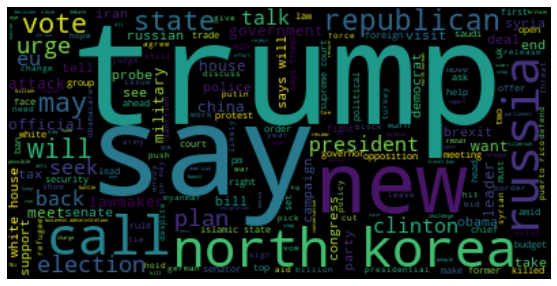


 Most popular words in Fake articles


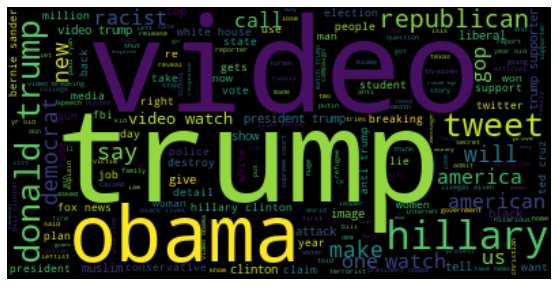

In [7]:
# Returns a string that contains all the text from the given column
def getColAsString(df, column):
  text = ''
  for index, row in df.iterrows():
    text += row[column]
  return text

# Given text, it prints its wordcloud plot (WordCloud handles the word ranking for us)
def printWordCloud(text):
  stopwords = set(STOPWORDS) # Ignore the stopwords in the wordcloud
  wordcloud = WordCloud(stopwords=stopwords).generate(text)
  plt.figure(figsize=(10,5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

# Print a word cloud for each article category
print(" Most popular words in Real articles")
text = getColAsString(true_df, 'title')
printWordCloud(text)

print("\n Most popular words in Fake articles")
text = getColAsString(fake_df, 'title')
printWordCloud(text)

# 2.β:
Οπτικοποίηση του μέσου όρου χαρακτήρων στα αληθινά ενάντια στα ψεύτικα άρθρα

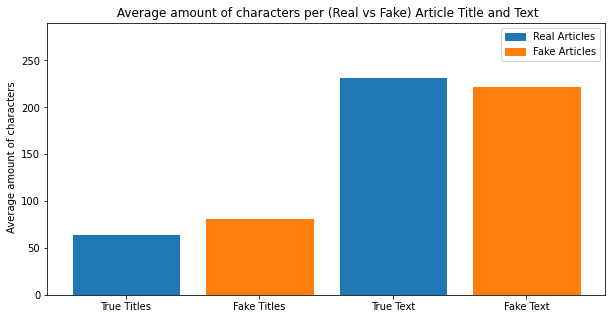

In [8]:
# Returns the average amount of characters in the given column of the given dataframe
def charCount(df, column):
  totalchars = 0
  for index, row in df.iterrows():
    totalchars += len(row[column])
  return totalchars/len(df)

# Etract the needed information
t_ti = charCount(true_df, 'title')
t_te = charCount(true_df, 'text')
f_ti = charCount(fake_df, 'title')
f_te = charCount(fake_df, 'text')

# And plot the results
plt.figure(figsize=(10,5))
plt.ylim([0, 290])
plt.title(' Average amount of characters per (Real vs Fake) Article Title and Text')
plt.ylabel(' Average amount of characters')

barplt = plt.bar( ['True Titles', 'Fake Titles', 'True Text', 'Fake Text'], [t_ti, f_ti, t_te, f_te] )

# Color code the plot
barplt[0].set_color('tab:blue')
barplt[2].set_color('tab:blue')
barplt[1].set_color('tab:orange')
barplt[3].set_color('tab:orange')

# And add a legend
blue_patch = mpatches.Patch(color='tab:blue', label='Real Articles')
orange_patch = mpatches.Patch(color='tab:orange', label='Fake Articles')
plt.legend(handles=[blue_patch, orange_patch])
plt.show()

Όσον αφορά το πλήθος των χαρακτήρων, φαίνεται τα ψεύτικα άρθρα να έχουν μεγαλύτερους κατα μέσο όρο τίτλους και μικρότερο περιεχόμενο συνολικά σχετικά με τα πραγματικά. (Αν και σε μικρό βαθμό)

Note: It would be interesting to run this without removing the sybols during preprocessing

# 2.γ:
Οπτικοποίηση των κατανομών πλήθους λέξεων σε τίτλους και κειμενο για αληθινά ενάντια σε ψεύτικα άρθρα <br/> (Με Stopwords)

In [9]:
# A function that breaks the given dictionary into two lists (keys : data) to allow easier plotting
def break_dict(d):
  keys = []
  data = []
  for key in d:
    keys.append(key)
    data.append(d[key])
  return (keys, data)

In [10]:
# Return a dictionary with all the article 'classes', based on the amount of words in the given column
def getWordDistribution(df, column):
  classes = dict()
  for index, row in df.iterrows():
    # Count the words in the given column
    wordCount = len(row[column].split())
    # And increment the correct class counter
    if wordCount not in classes:
      classes[wordCount] = 0
    else:
      classes[wordCount] += 1
  return classes

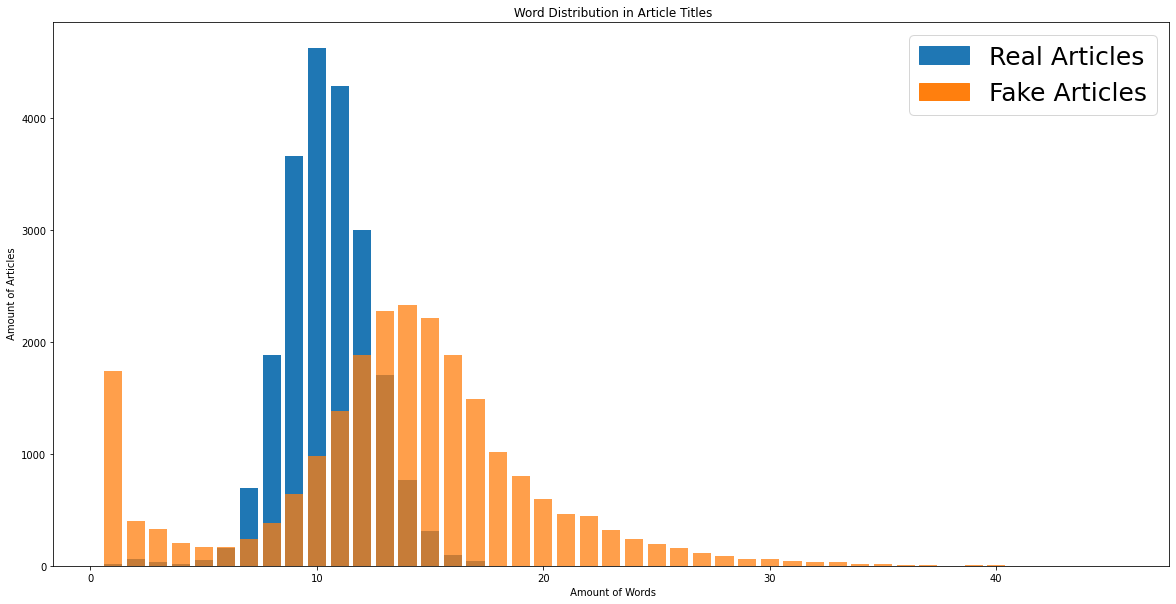

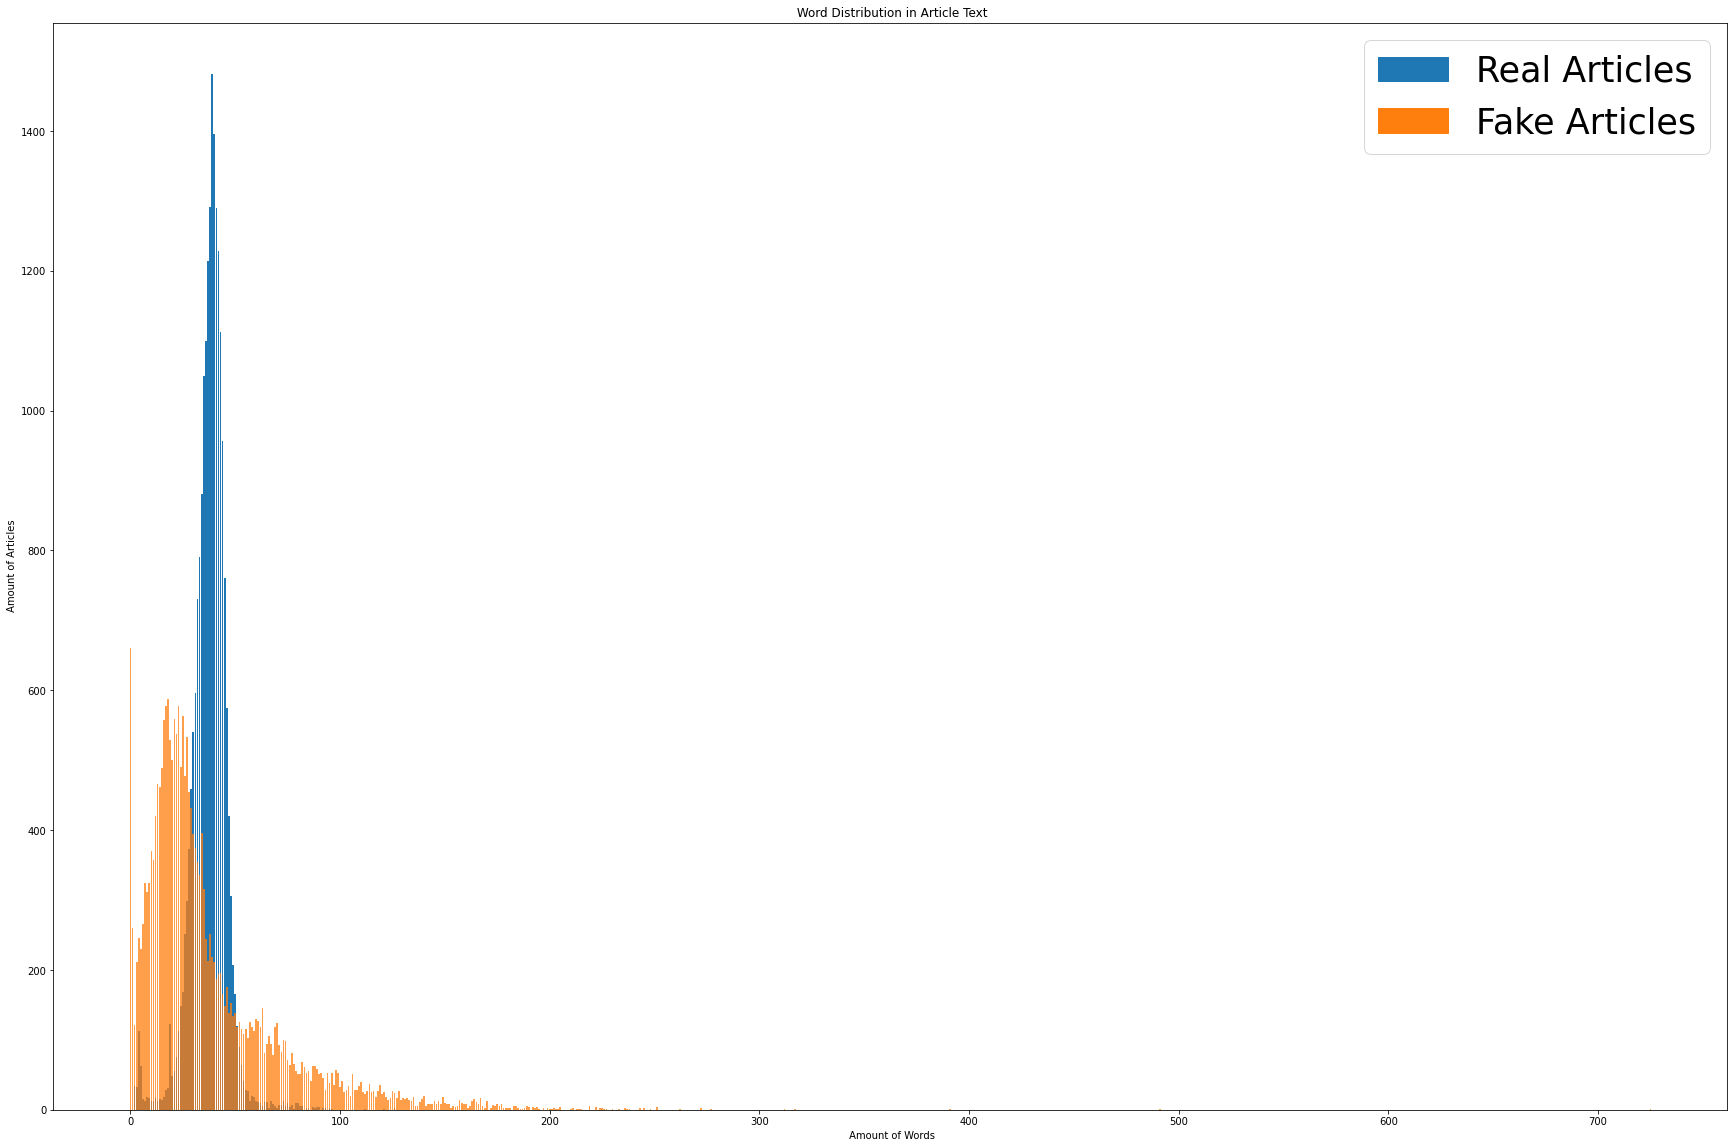

In [11]:
# Prepare the legends
blue_patch = mpatches.Patch(color='tab:blue', label='Real Articles')
orange_patch = mpatches.Patch(color='tab:orange', label='Fake Articles')

# Plot the results for Article Titles
plt.figure(figsize=(20,10))
keys, data = break_dict( getWordDistribution(true_df, 'title') )
plt.bar(keys, data)
plt.title(' Word Distribution in Article Titles')
plt.ylabel(' Amount of Articles')
plt.xlabel(' Amount of Words')
keys, data = break_dict( getWordDistribution(fake_df, 'title') )
plt.bar(keys, data, alpha=0.75)
plt.legend(handles=[blue_patch, orange_patch], prop={'size': 25})
plt.show()
print()

# Plot the results for Article Text
plt.figure(figsize=(30,20))
keys, data = break_dict( getWordDistribution(true_df, 'text') )
plt.bar(keys, data)
plt.title(' Word Distribution in Article Text')
plt.ylabel(' Amount of Articles')
plt.xlabel(' Amount of Words')
keys, data = break_dict( getWordDistribution(fake_df, 'text') )
plt.bar(keys, data, alpha=0.75)
plt.legend(handles=[blue_patch, orange_patch], prop={'size': 35})
plt.show()

Όπως και σε επίπεδο χαρακτήρων παραπάνω, έτσι και σε επίπεδο λέξεων, φαίνεται να ακολουθείται η ίδια τάση από τα ψεύτικα άρθρα: "Κατα μέσο όρο μεγαλύτεροι τίτλοι με συντομότερο περιεχόμενο" <br/>

Ειδικά από το γράφημα περιεχομένου-λέξεων γίνεται πιο αισθητός ο διαχωρισμός μεταξύ πραγματικών και ψεύτικων άρθρων, με ξεκάθαρο διαχωρισμό μεταξύ των δύο κατανομών. Απο πλευράς λέξεων, η μεγάλη πλειοψηφία των ψευτικων άρθρων έχει σημαντικά λιγότερες λέξεις από το μέσο πραγματικό άρθρο. Ταυτόχρονα, ενώ τα πραγματικά άρθρα ακολουθούν μια αναμενόμενα κανονική κατανομή, τα ψεύτικα, ξεχωρίζουν από την τάση της κατανομής τους προς τις μικρές τιμές και το σημαντικά μεγαλύτερο (σχεδόν διπλάσιο) εύρος τους. Αρκετά Ψευτικά άρθρα εχουν μεγάλο πλήθος λέξεων, πιθανότατα επειδή για κάποιους χρήστες-στοχους το μέγεθος του κειμένου, του προσθέτει και αξιοπιστία.

# 2.δ:
Οπτικοποίηση των κατανομών πλήθους λέξεων σε τίτλους και κειμενο για αληθινά ενάντια σε ψεύτικα άρθρα <br/> (Χωρίς Stopwords)

Αφαιρούμε τα stopwords από τα δεδομένα μας και ξανακάνουμε τις μετρήσεις μας

In [12]:
data = [true_df, fake_df]

# Remove all the stopwords from the dataframe fields
for df in data:
  for index, row in df.iterrows():
    row['title'] = remove_stopwords( row['title'] )
    row['text'] = remove_stopwords( row['text'] )

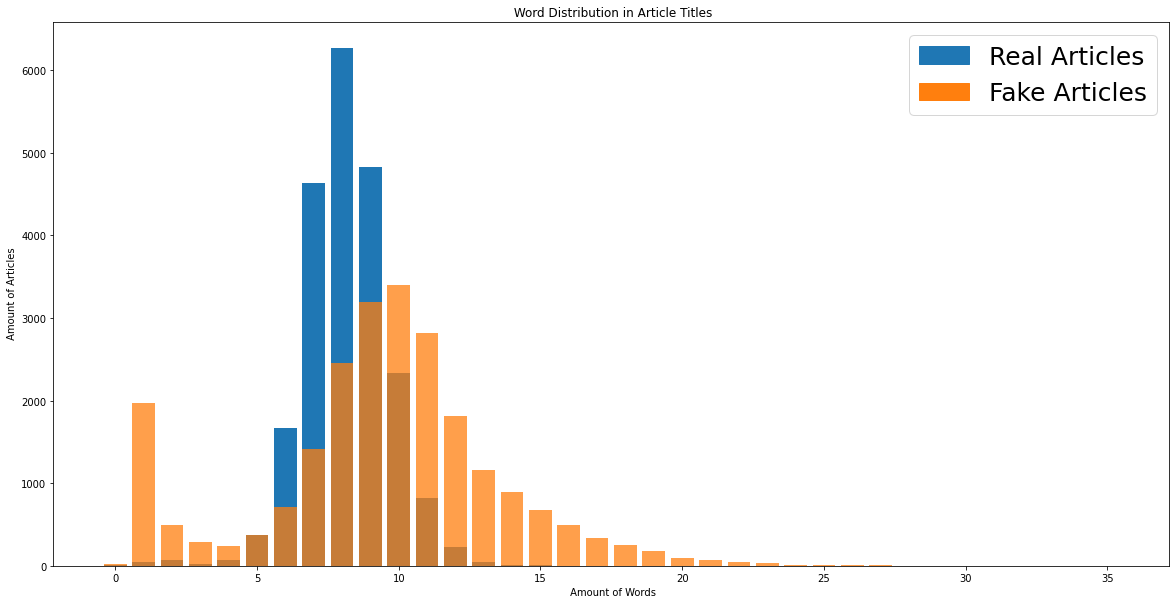

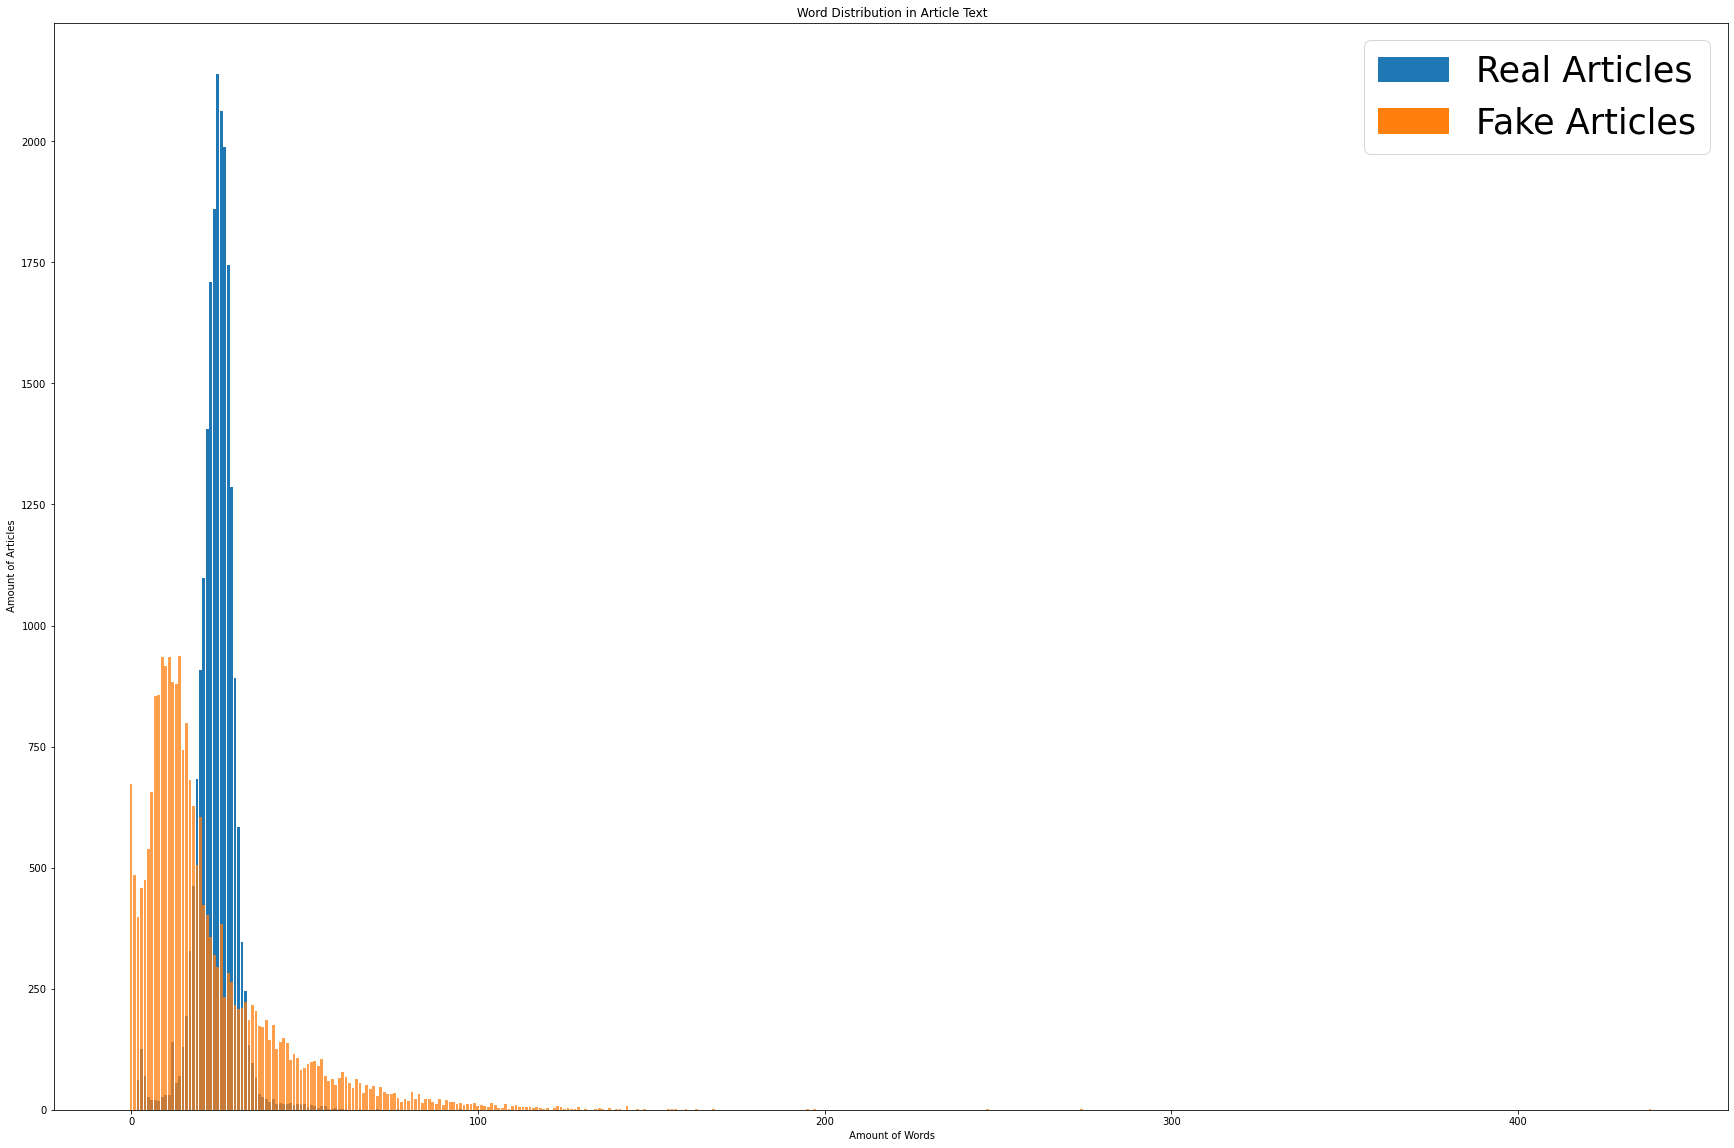

In [13]:
# Prepare the legends
blue_patch = mpatches.Patch(color='tab:blue', label='Real Articles')
orange_patch = mpatches.Patch(color='tab:orange', label='Fake Articles')

# Plot the results for Article Titles
plt.figure(figsize=(20,10))
keys, data = break_dict( getWordDistribution(true_df, 'title') )
plt.bar(keys, data)
plt.title(' Word Distribution in Article Titles')
plt.ylabel(' Amount of Articles')
plt.xlabel(' Amount of Words')
keys, data = break_dict( getWordDistribution(fake_df, 'title') )
plt.bar(keys, data, alpha=0.75)
plt.legend(handles=[blue_patch, orange_patch], prop={'size': 25})
plt.show()
print()

# Plot the results for Article Text
plt.figure(figsize=(30,20))
keys, data = break_dict( getWordDistribution(true_df, 'text') )
plt.bar(keys, data)
plt.title(' Word Distribution in Article Text')
plt.ylabel(' Amount of Articles')
plt.xlabel(' Amount of Words')
keys, data = break_dict( getWordDistribution(fake_df, 'text') )
plt.bar(keys, data, alpha=0.75)
plt.legend(handles=[blue_patch, orange_patch], prop={'size': 35})
plt.show()

Η αφαίρεση των stopwords δεν επηρέασε σημαντικά τις κατανομές και τις παρατηρήσεις μας. Υποθέτουμε πως η αφαίρεση των stopwords από τα ψεύτικα άρθρα "αντισταθμίζεται" σε κάποιο βαθμό από αυτή στα αληθινά με αποτέλεσμα να μην επηρεάζονται σημαντικά τα τελικά αποτελέσματα - κατανομές.

# 2.ε:
Ποια είναι τα πιο συχνά bigrams στους τίτλους και ποιά στο κυρίως άρθρο;

In [14]:
# Find frequency of bigrams in our dataframes' titles and texts
# We have removed stoprwords in this steps in order to get more informative results

def bigramFrequency(df, column, topk):
  # Make a CountVectorizer model with max_festures to find only the top k bigrams we want
  word_vectorizer = CountVectorizer(ngram_range=(2,2),max_features=topk, analyzer='word')  
  # Train it using the desired column from the dataframe
  sp_matrix = word_vectorizer.fit_transform(df[column])      
  # Store the frequencies as an array            
  frequencies = sum(sp_matrix).toarray()[0]
  # Convert frequencies to a dataframe in order to present them in a more easy for the eye way
  bigr_df = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['Frequency'])
  # Sort values in a descending order
  bigr_df = bigr_df.sort_values('Frequency', ascending=False)                                             
  display(bigr_df)
  print()

bigramFrequency(true_df,'title',10)
bigramFrequency(true_df,'text',10)
bigramFrequency(fake_df,'title',10)
bigramFrequency(fake_df,'text',10)

,Frequency
white house,788
north korea,716
trump says,360
islamic state,251
supreme court,234
puerto rico,178
south korea,160
travel ban,156
says trump,151
trump administration,148


,Frequency
washington reuters,6663
donald trump,6065
president donald,3698
reuters president,2311
united states,1595
white house,1435
new york,1302
said wednesday,1266
prime minister,1217
said thursday,1190


,Frequency
donald trump,727
president trump,392
hillary clinton,342
white house,314
fox news,287
trump video,221
bernie sanders,220
ted cruz,207
boiler room,201
anti trump,199


,Frequency
donald trump,5271
hillary clinton,1395
21st century,999
white house,934
president trump,882
century wire,815
united states,728
wire says,717
president obama,702
fox news,566


# **Ερώτημα 3:**
**Δημιουργία συνόλου εκμάθησης και δοκιμής**

In [15]:
# Create a dataframe based on equal amounts of true and fake articles
# (containing part of the initial dataset for better testing performance)
true_df_sliced = true_df.head(2400)
true_df_sliced.insert(4,'label','1')
fake_df_sliced = fake_df.head(2400)
fake_df_sliced.insert(4,'label','0')
merged_df = pd.concat([true_df_sliced,fake_df_sliced], ignore_index=True)

# Create the train and test dataset themselves
train = merged_df.sample(frac=0.8,random_state=250)
test = merged_df.drop(train.index)
# And store them in files as required
train.to_csv(r'/content/gdrive/MyDrive/DataMining2021/TEDE_SHARED/train.csv', index=False)
test.to_csv(r'/content/gdrive/MyDrive/DataMining2021/TEDE_SHARED/test.csv', index=False)

print("Merged length:",len(merged_df),", train length:",len(train),', test length:',len(test), '\n')
# display(train.tail(1))
# print('\n')
# display(test.tail(1))

Merged length: 4800 , train length: 3840 , test length: 960 



---
# **Μέρος 2ο**
---

Για μεγαλύτερη ευκολία/ευελιξία, δημιουργήσαμε για το κομμάτι αυτό ενα ξεχωριστό dataframe και κατα συνέπεια διαφορετικά train και test dataframes. Το dataframe αυτό αποτελείται από τα δεδομένα μας σε διαφορετικά 'στιγμιότυπα' επεξεργασίας σε κάθε στήλη, από τα 'ωμα'-αρχικά δεδομένα, σε δεδομένα χωρις stopwords και lemmatized. Φτιάξαμε ετσι τα δεδομένα μας ωστε να έχουμε την ευελιξία με αλλαγή μόλις μιας παραμέτρου να μπορούμε να συγκρίνουμε την απόδοση των δεδομένων μας σε διαφορετικά σταδια επεξεργασίας, χωρις αναμονές καθώς ειναι όλα έτοιμα-προεπεξεργασμένα.

# **Representations**

In [16]:
# Create the train and test data/labels using the built in function train_test_split()
traindata, testdata, trainlabel, testlabel = train_test_split(format_df['Lemmatized'], format_df['Label'],train_size=0.8, random_state=250, stratify=format_df['Label'])

# Create all the different data representations that we will be working on:

# BoW: Create a bow vectorizer, fit to it the train data and then transform the testing data 
# using the resulting bow, to end up with two BoWs that have the same amount of characteristics 
bow = CountVectorizer()
traindata_bow = bow.fit_transform(traindata)
testdata_bow = bow.transform(testdata)

# TF-IDF: Create the tf-idf transformer using the generated BoWs from above
tfidf = TfidfTransformer()
traindata_tfidf = tfidf.fit_transform(traindata_bow)
testdata_tfidf  = tfidf.transform(testdata_bow)

In [17]:
# The word2vec vector size = the amount of 'features' of each word
feature_amount = 256 

# Returns an array containing the document vectors of each article from the given dataset
def getDocVec(dataset, model):
  # Get the document-feature vectors for each record-article of the train data
  data_list = [] # Store all the data vectors in this list

  # Get each article in the data
  for i, row in dataset.to_frame().iterrows():
    # Temporary array to store this row's vectors, initialized in zeros to act as an 'article-global' averaging vector
    avg_vec = np.zeros(feature_amount)   
    # Get the words of this article
    tokens = nltk.word_tokenize(row['Lemmatized'])

    # For every word in this article
    for token in tokens:
      # If it exists on our Word2vec dictionary
      if token in model.wv:
        # We add this word's vector to the article's total average vector, averaged by its word length
        avg_vec += (model.wv[token]/len(tokens))

    # Store the resulting document vector
    data_list.append(avg_vec)

  # Return the resulting list as an array
  return np.array(data_list)

In [18]:
# Word2Vec:

# Break the train data into tokens to pass to word2vec 
# (We use only train data to train the model)
tokens = [nltk.word_tokenize(strings) for strings in traindata.to_frame()['Lemmatized']]

# Initialize and train the word2vec model
# (We ended up with these parameter values after a bit of trial and error)
w2v_model = Word2Vec(min_count=2, size=256, workers=multiprocessing.cpu_count(), window=5 , sg=0)
w2v_model.build_vocab(tokens)
w2v_model.train(tokens, total_examples=len(tokens), epochs=8)

# Get the document vectors for each dataset
traindata_w2v = getDocVec(traindata, w2v_model)
testdata_w2v  = getDocVec(testdata, w2v_model)

In [19]:
# Add the min value of each vector array as an offset to the array to make it non-negative
# And allow it to work with MultinomialNB() in Naive Bayes
# It does not alter the data or change the accuracy, it just 'shifts' it to make it positive
trainmin = np.amin(traindata_w2v)
testmin = np.amin(testdata_w2v)

if trainmin < 0 :
  traindata_w2v += abs(trainmin)

if testmin < 0 :
  testdata_w2v += abs(testmin)

# print(np.amin(traindata_w2v))
# print(np.amin(testdata_w2v))

In [20]:
# Flag. If set to 1, it enables analytic classification reports ( classification_report() )
analStats = 0

# **Logistic Regression**

 > Logistic Regression using BoW
 Accuracy: 99.61%
 F1 Score: 99.59%


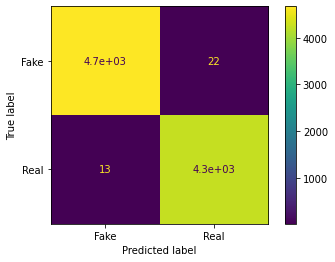



 > Logistic Regression using TF-IDF
 Accuracy: 98.65%
 F1 Score: 98.59%


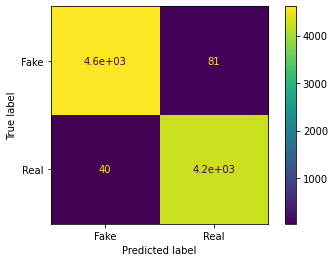



 > Logistic Regression using Word2Vec
 Accuracy: 98.25%
 F1 Score: 98.18%


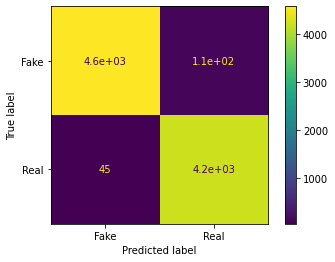

In [21]:
# Given the train and test data/labels, it calculates and prints the accuracy and f1 score of a Logistic regression model 
def LogisticClassification(traindata, trainlabel, testdata, testlabel):
  # Create a logistic regression model
  model = LogisticRegression(max_iter=1000)
  # Fit the train dat to it
  model.fit(traindata, trainlabel)
  # Make a prediction
  prediction = model.predict(testdata)
  # Get the true/false positive/negative results using a confusion matrix
  tn, fp, fn, tp = confusion_matrix(testlabel, prediction).ravel()

  # Get a full acurracy report
  if (analStats == 1):
    print( classification_report(testlabel.to_frame(),prediction) )

  # Calculate and Print the scores (Use true/false positive/negative to calculate the f1 score)
  print(' Accuracy: %.2f%%' % (accuracy_score(testlabel, prediction)*100) )
  print(' F1 Score: %.2f%%' % ( (tp/(tp+(fp+fn)/2))*100) )

  # Finally, plot the comfusion matrix for a better visualization
  plot_confusion_matrix(model, testdata, testlabel, display_labels=['Fake', 'Real', 'Fake', 'Real'])  
  plt.show()  
  print('\n')
  
# Run a test for each representation
print(" > Logistic Regression using BoW")
LogisticClassification(traindata_bow, trainlabel, testdata_bow, testlabel)
print(" > Logistic Regression using TF-IDF")
LogisticClassification(traindata_tfidf, trainlabel, testdata_tfidf, testlabel)
print(" > Logistic Regression using Word2Vec")
LogisticClassification(traindata_w2v, trainlabel, testdata_w2v, testlabel)

# **Naive Bayes**

 > Naive Bayes using BoW
 Accuracy: 95.28%
 F1 Score: 95.05%


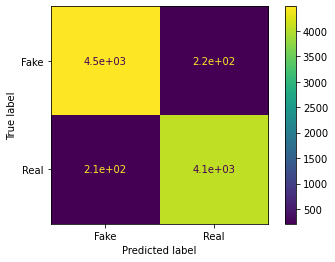



 > Naive Bayes using TF-IDF
 Accuracy: 93.65%
 F1 Score: 93.29%


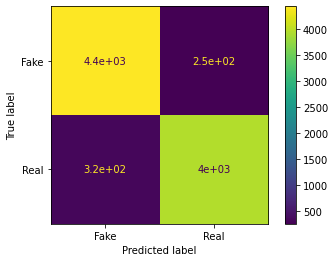



 > Naive Bayes using Word2Vec
 Accuracy: 90.31%
 F1 Score: 90.03%


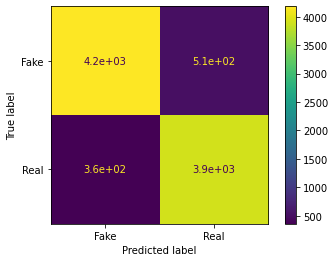

In [22]:
# Given the train and test data/labels, it calculates and prints the accuracy and f1 score of a Naive Bayes model 
def naiveBayesClassification(traindata, trainlabel, testdata, testlabel):
  # Create a naive Bayes classification model
  model = MultinomialNB()

  # Fit the train data to it
  model.fit(traindata, trainlabel)

  # Make a prediction
  prediction = model.predict(testdata)
  # Get the true/false positive/negative results using a confusion matrix
  tn, fp, fn, tp = confusion_matrix(testlabel, prediction).ravel()
  # Get a full acurracy report
  if (analStats == 1):
    print( classification_report(testlabel.to_frame(),prediction) )

  # Calculate and Print the scores (Use true/false positive/negative to calculate the f1 score)
  print(' Accuracy: %.2f%%' % (accuracy_score(testlabel, prediction)*100) )
  print(' F1 Score: %.2f%%' % ( (tp/(tp+(fp+fn)/2))*100) )

  # Finally, plot the comfusion matrix for a better visualization
  plot_confusion_matrix(model, testdata, testlabel, display_labels=['Fake', 'Real', 'Fake', 'Real'])  
  plt.show()  
  print('\n')

# Run a test for each representation
print(" > Naive Bayes using BoW")
naiveBayesClassification(traindata_bow, trainlabel, testdata_bow, testlabel)
print(" > Naive Bayes using TF-IDF")
naiveBayesClassification(traindata_tfidf, trainlabel, testdata_tfidf, testlabel)
print(" > Naive Bayes using Word2Vec")
naiveBayesClassification(traindata_w2v, trainlabel, testdata_w2v, testlabel)

# **Support Vector Machines**

 > SVM using BoW with linear kernel


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 Accuracy: 99.49%
 F1 Score: 99.46%


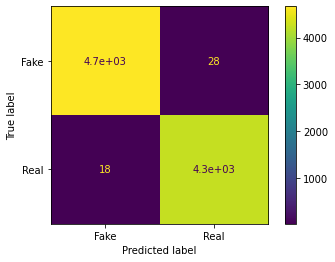



 > SVM using TF-IDF linear kernel
 Accuracy: 99.52%
 F1 Score: 99.50%


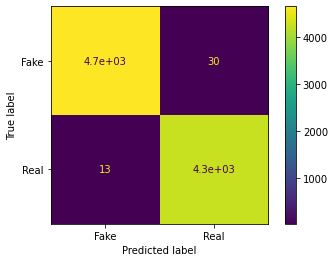



 > SVM using Word2Vec with linear kernel


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


 Accuracy: 97.10%
 F1 Score: 97.05%


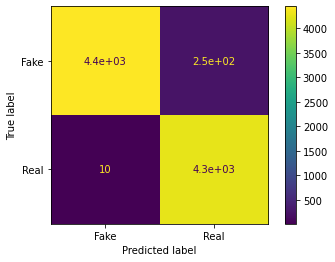

In [23]:
# Given the train and test data/labels, it calculates and prints the accuracy and f1 score of a SVM model 
def svmClassification(traindata, trainlabel, testdata, testlabel, kernel_type):
  # Create a SVM classification model
  model = svm.LinearSVC(random_state=0, tol=1e-5)
  # Fit the train dat to it
  model.fit(traindata, trainlabel)
  # Make a prediction
  prediction = model.predict(testdata)
  # Get the true/false positive/negative results using a confusion matrix
  tn, fp, fn, tp = confusion_matrix(testlabel, prediction).ravel()

  # Get a full acurracy report
  if (analStats == 1):
    print( classification_report(testlabel.to_frame(),prediction) )

  # Calculate and Print the scores (Use true/false positive/negative to calculate the f1 score)
  print(' Accuracy: %.2f%%' % (accuracy_score(testlabel, prediction)*100) )
  print(' F1 Score: %.2f%%' % ( (tp/(tp+(fp+fn)/2))*100) )

  # Finally, plot the comfusion matrix for a better visualization
  plot_confusion_matrix(model, testdata, testlabel, display_labels=['Fake', 'Real', 'Fake', 'Real'])  
  plt.show()  
  print('\n')

# Run a test for each representation
print(" > SVM using BoW with linear kernel")
svmClassification(traindata_bow, trainlabel, testdata_bow, testlabel,'linear')
print(" > SVM using TF-IDF linear kernel")
svmClassification(traindata_tfidf, trainlabel, testdata_tfidf, testlabel,'linear')
print(" > SVM using Word2Vec with linear kernel")
svmClassification(traindata_w2v, trainlabel, testdata_w2v, testlabel,'linear')

Κάναμε αρκετές δοκιμές με χρήση ποικιλίας παραμέτρων καθώς και δοκιμές με την χρήση GridSearchCV και καταλήξαμε στα εξής:

Σε γενικές γραμμές, με το rdf kernel είχαμε λίγο χειρότερη ακρίβεια και με μεγάλο κόστος σε χρονική πολυπλοκότητα. Θεωρούμε ότι για τις ανάγκες μας στην συγκεκριμένη περίπτωση ο linear svc επιτυγχάνει εξαιρετικά αποτελέσματα σε ελάχιστο χρόνο οπότε και τον προτιμήσαμε.

# **Random Forest**

 > Random Forest using BoW
 Accuracy: 99.42%
 F1 Score: 99.39%


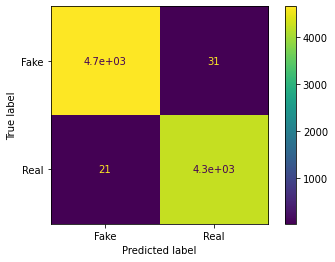



 > Random Forest using TF-IDF
 Accuracy: 99.11%
 F1 Score: 99.07%


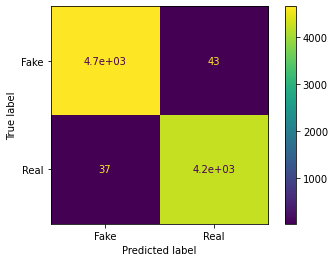



 > Random Forest using Word2Vec
 Accuracy: 89.81%
 F1 Score: 89.85%


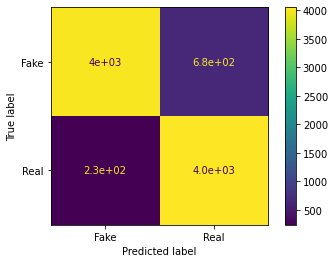

In [24]:
# Given the train and test data/labels, it calculates and prints the accuracy and f1 score of a Random Forest model 
def randomForestClassification(traindata, trainlabel, testdata, testlabel):
  # Create a RandomForest classification model
  model = RandomForestClassifier(random_state=164)
  # Fit the train dat to it
  model.fit(traindata, trainlabel)
  # Make a prediction
  prediction = model.predict(testdata)
  # Get the true/false positive/negative results using a confusion matrix
  tn, fp, fn, tp = confusion_matrix(testlabel, prediction).ravel()

  # Get a full acurracy report
  if (analStats == 1):
    print( classification_report(testlabel.to_frame(),prediction) )

  # Calculate and Print the scores (Use true/false positive/negative to calculate the f1 score)
  print(' Accuracy: %.2f%%' % (accuracy_score(testlabel, prediction)*100) )
  print(' F1 Score: %.2f%%' % ( (tp/(tp+(fp+fn)/2))*100) )

  # Finally, plot the comfusion matrix for a better visualization
  plot_confusion_matrix(model, testdata, testlabel, display_labels=['Fake', 'Real', 'Fake', 'Real'])  
  plt.show()  
  print('\n')

#Run a test for each representation
print(" > Random Forest using BoW")
randomForestClassification(traindata_bow, trainlabel, testdata_bow, testlabel)
print(" > Random Forest using TF-IDF")
randomForestClassification(traindata_tfidf, trainlabel, testdata_tfidf, testlabel)
print(" > Random Forest using Word2Vec")
randomForestClassification(traindata_w2v, trainlabel, testdata_w2v, testlabel)

---
# **Μέρος 3ο**
---

Σε γενικές γραμμές, κατά την υλοποίηση των παραπάνω classifiers, προσπαθήσαμε να τους κάνουμε να λειτουργούν όσο το δυνατόν καλύτερα για τα δεδομένα όπως τους τα δίνουμε.<br/><br/>

Για να βελτιώσουμε τα αποτελέσματα μας, προσπαθήσαμε να κάνουμε fine-tune τις παραμέτρους των classifiers, όπου αυτό ήταν δυνατό/αποτελεσματικό. Ακόμα, δοκιμάσαμε και εναλλακτικούς/υποκατάστατους classifiers (πχ LinearSVC)
<br/><br/>

Θεωρούμε ότι καταφέραμε αρκετά καλά αποτελέσματα across the board, με τους περισσότερους classifiers να επιτυγχάνουν ακρίβεια της τάξης 97%-99%. (Αναμενόμενο καθώς το dataset πανω στο οποίο δουλεύουμε είναι αρκετά εύκολο)
<br/><br/>

Χαμηλότερες ακρίβειες, έχουμε μόνο στον Naive Bayes και για τα τρια representations, και στο Random Forest μόνο για το word2Vec. (Τάξης 90%-95%)
<br/><br/>

Έχουμε ήδη αφιερώσει αρκετό χρόνο κάνοντας δοκιμές ωστε να βελτιώσουμε όλους τους classifiers του προηγούμενου ερωτήματος και έχουμε πετύχει αρκετά υψηλές ακρίβειες, οπότε δεν αναμένουμε να επιτύχουμε ιδιαίτερα μεγάλη βελτίωση στο ερώτημα αυτό.   

Παρακάτω λοιπόν, θα προσπαθήσουμε να βελτιώσουμε την ακρίβεια του Naive Bayes Classifier, για bow και tfidf όσο το δυνατόν περισσότερο.



Ένας τρόπος να βελτιώσουμε την ακρίβεια, είναι να "καθαρίσουμε" καλύτερα τα αρχικά μας δεδομένα, ή να σκεφτούμε νέα ευρετικά χαρακτηριστικά για τα δεδομένα μας και να τα προσθέσουμε στα χαρακτηριστικά που προκύπτουν από τις διάφορες αναπαραστάσεις.

Έχουμε κάνει όλα τα βήματα προεπεξεργασίας και κανονικοποίησης δεδομένων που θεωρήσαμε πως μπορούν να βελτώσου τις επιδώσεις των μεθόδων μας, στο πρώτο κομμάτι της εργασίας. Έτσι στο σημείο αυτό πειραματιστήκαμε κυρίως με προσθήκη νέων χαρακτηριστικών απο εμας για βελτίωση της ακρίβειας.






# Προσθήκη χαρακτηριστικών


Με βάση τις παρατηρήσεις μας στο ερώτημα 2.β, μια ιδέα είναι να προσθέσουμε στήλες με τα πλήθη των χαρακτήρων στους τίτλους και στα κείμενα αντίστοιχα. Υπενθυμίζουμε οτι στο 2.β, παρατηρήσαμε πως τα ψεύτικα άρθρα τείνουν να έχουν μεγαλύτερους τίτλους και μικρότερο περιεχόμενο σχετικά με τα αληθινά.

Φτιάξαμε μια στήλη με το πλήθος των συμβολων σε κάθε άρθρο, και άλλη μια με μια δική μας "μετρική", που προσπαθήσαμε με βάση την παραπάνω παρατήρηση να μεταφράσουμε πλήθος χαρακτήρων τίτλου και κειμένου, σε χαρακτηριστικό με κατανομή τέτοια ωστε να επιτρέπει classification. (True: μικρός τίτλος, μεγάλο περιεχόμενο, Fake: μεγάλος τίτλος, μικρό περιεχόμενο => χρησιμοποιούμε τις ιδιότητες αριθμητή/παρανωμαστή κλασμάτων και το κανονικοποιούμε διαιρώντας με το συνολικό πλήθος χαρακτήρων)

In [25]:
# Adds the given 'characteristic-vector' to the existing ones (For both train and test sets)
def addExtraHeur(traindata, testdata, newtraindata, newtestdata):
  newtrn = np.array(newtraindata)
  newtst = np.array(newtestdata)

  new_traindata_bow = sparse.hstack( (traindata, newtrn[:, None]))
  new_testdata_bow = sparse.hstack( (testdata, newtst[:, None]))

  return (new_traindata_bow, new_testdata_bow)

 Accuracy: 94.68%
 F1 Score: 94.37%


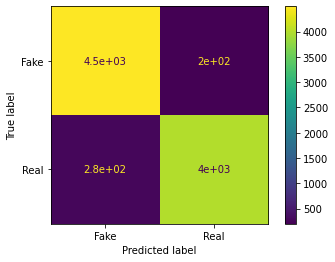

In [26]:
# We get the needed characteristics through train_test_split using the same parameters as above to ensure we have the correct order
tit_traindata, tit_testdata, tit_trainlabel, tit_testlabel = train_test_split(format_df['titleLens'], format_df['Label'],train_size=0.8, random_state=250, stratify=format_df['Label'])
met_traindata, met_testdata, met_trainlabel, met_testlabel = train_test_split(format_df['lenMetric'], format_df['Label'],train_size=0.8, random_state=250, stratify=format_df['Label'])

# We add the heuristics to the representation we want
new_traindata_bow, new_testdata_bow = addExtraHeur(traindata_bow, testdata_bow, tit_traindata, tit_testdata)
new_traindata_bow, new_testdata_bow = addExtraHeur(new_traindata_bow, new_testdata_bow, met_traindata, met_testdata)

# And calculate the new result
naiveBayesClassification(new_traindata_bow, trainlabel, new_testdata_bow, testlabel)

Δυστυχώς βλέπουμε ότι τα επιπλέον χαρακτηριστικά μειώνουν κατα πολύ λιγο τις ακρίβειες μας. (Όσα χαρακτηριστικά και αν σκεφτήκαμε να δοκιμάσουμε)

---
Σημείωση: Προσπαθήσαμε να επιλέξουμε χαρακτηριστικά, των οποίων οι κατανομές να μπορούν να δώσουν χρήσιμη πληροφορία κατηγοριοποίησης, τυπώνοντας τις κατανομές τους

In [27]:
# Return a dictionary with all the article 'classes', based on the amount of words in the given column
def getNumDistribution(df, column):
  pos = dict()
  neg = dict()

  for index, row in df.iterrows():
    # num = round(row[column])
    num = row[column]
    if row['Label'] == '1':
      if num not in pos:
        pos[num] = 1
      else:
        pos[num] += 1
    else:
      if num not in neg:
        neg[num] = 1
      else:
        neg[num] += 1

  return (pos, neg)

<BarContainer object of 207 artists>

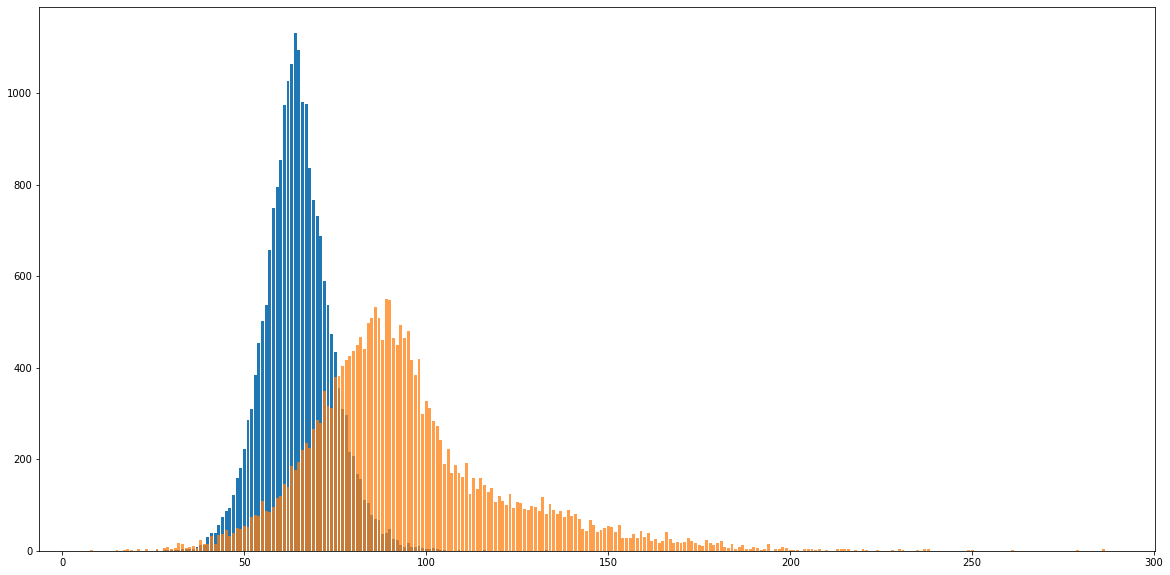

In [28]:
plt.figure(figsize=(20,10))
posdict, negdict = getNumDistribution(format_df, 'titleLens')

keys, data = break_dict( posdict )
plt.bar(keys, data)
keys, data = break_dict( negdict )
plt.bar(keys, data, alpha=0.75)

(Βγαίνει περιεργο, αλλα χρησιμοποιησαμε plot αντι για bar σε κάποιες περιπτώσεις καθώς αντιμετοπίσαμε κάποια προβλήματα για πολύ μεγάλες κατανομές, και με την plot φαίνεται η πληροφορία που θέλουμε αξιοπρεπώς)

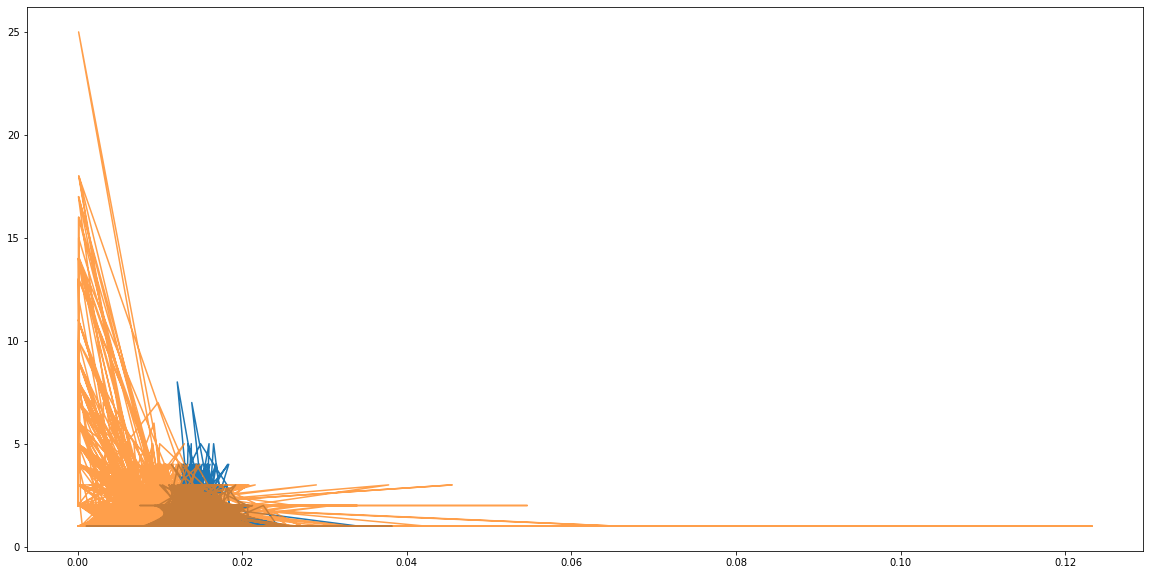

In [29]:
plt.figure(figsize=(20,10))
posdict, negdict = getNumDistribution(format_df, 'lenMetric')

keys, data = break_dict( posdict )
plt.plot(keys, data)
keys, data = break_dict( negdict )
plt.plot(keys, data, alpha=0.75)

Βλέπουμε ότι υπάρχει διαχωρισμός, αλλα δυστυχώς δεν βλέπουμε καμία βελτίωση στα τελικά μας αποτελέσματα, ίσα ισα παρατηρούμε μια μικρή μείωση στις ακρίβειες μας.

---

Στην προσπάθεια μας να βρούμε επιπλέον χρήσιμα χαρακτηριστικά για να βελτιώσουμε τις επιδώσεις του classifier μας, 
δοκιμάσαμε να προσθέσουμε στα χαρακτηριστικά μας, και τις πληροφορίες 'Θέματος' και 'Ημερομηνίας' των άρθρων.
Προς εκπληξη μας, η προσθήκη αυτή, μαζί με μια μικρή βελτίωση που προήλθε από το fine tuning των παραμέτρων του
classifier, οδήγησαν τελικά σε μια βελτίωση της τάξης του 2% με 5%

In [30]:
# Returns a list that contains all the words of each dataframe record in a srting
def getRecStrList(df):
  trainList = []
  for index, row in df.iterrows():
    txt = str(row['title']) + ' ' + str(row['text']) + ' ' + str(row['subject']) + ' ' + str(row['date'])
    trainList.append(txt)
  return trainList

# Based on the true and fake dataframes, get a dataframe the data in a lot of different processed formats
# to use for better testing down the line
def getInitialFormat(true_df, fake_df):
  # Create copies of the initial dataframes to not affect them
  tmp_true = true_df.copy()
  tmp_fake = fake_df.copy()
  # tmp_true = true_df.head(2400).copy()
  # tmp_fake = fake_df.head(2400).copy()

  # Add the label column and merge the two dataframes
  tmp_fake.insert(0,'label','0')
  tmp_true.insert(0,'label','1')
  tmp_df = pd.concat([tmp_true,tmp_fake], ignore_index=True)

  # Create the new dataframe and add the processed level columns
  format_df = pd.DataFrame()
  format_df['Label'] = tmp_df['label']
  format_df['RAW']   = getRecStrList(tmp_df)
  format_df['Symbol'] = format_df['RAW'].str.lower().replace(r'\s+', ' ', regex=True)
  format_df['Preprocess'] = format_df['Symbol'].str.replace(r'[^a-zA-Z0-9]', ' ', regex=True)
  format_df['StopWords'] = format_df['Preprocess'].apply( remove_stopwords )
  format_df['Lemmatized'] = format_df['StopWords'].apply( lemmatize )

  return format_df

# (Mostly Used in the 2nd and 3rd part of the assignment for tests)
format_df = getInitialFormat(true_df, fake_df)

In [31]:
# Create the train and test data/labels using the built in function train_test_split()
traindata, testdata, trainlabel, testlabel = train_test_split(format_df['Lemmatized'], format_df['Label'],train_size=0.8, random_state=250, stratify=format_df['Label'])

# Create all the different data representations that we will be working on:

# BoW: Create a bow vectorizer, fit to it the train data and then transform the testing data 
# using the resulting bow, to end up with two BoWs that have the same amount of characteristics 
bow = CountVectorizer()
traindata_bow = bow.fit_transform(traindata)
testdata_bow = bow.transform(testdata)

# TF-IDF: Create the tf-idf transformer using the generated BoWs from above
tfidf = TfidfTransformer()
traindata_tfidf = tfidf.fit_transform(traindata_bow)
testdata_tfidf  = tfidf.transform(testdata_bow)

In [32]:
# The word2vec vector size = the amount of 'features' of each word
feature_amount = 256 

# Returns an array containing the document vectors of each article from the given dataset
def getDocVec(dataset, model):
  # Get the document-feature vectors for each record-article of the train data
  data_list = [] # Store all the data vectors in this list

  # Get each article in the data
  for i, row in dataset.to_frame().iterrows():
    # Temporary array to store this row's vectors, initialized in zeros to act as an 'article-global' averaging vector
    avg_vec = np.zeros(feature_amount)   
    # Get the words of this article
    tokens = nltk.word_tokenize(row['Lemmatized'])

    # For every word in this article
    for token in tokens:
      # If it exists on our Word2vec dictionary
      if token in model.wv:
        # We add this word's vector to the article's total average vector, averaged by its word length
        avg_vec += (model.wv[token]/len(tokens))

    # Store the resulting document vector
    data_list.append(avg_vec)

  # Return the resulting list as an array
  return np.array(data_list)

In [33]:
# Word2Vec:

# Break the train data into tokens to pass to word2vec 
# (We use only train data to train the model)
tokens = [nltk.word_tokenize(strings) for strings in traindata.to_frame()['Lemmatized']]

# Initialize and train the word2vec model
# (We ended up with these parameter values after a bit of trial and error)
w2v_model = Word2Vec(min_count=2, size=256, workers=multiprocessing.cpu_count(), window=5 , sg=0)
w2v_model.build_vocab(tokens)
w2v_model.train(tokens, total_examples=len(tokens), epochs=8)

# Get the document vectors for each dataset
traindata_w2v = getDocVec(traindata, w2v_model)
testdata_w2v  = getDocVec(testdata, w2v_model)

In [34]:
# Add the min value of each vector array as an offset to the array to make it non-negative
# And allow it to work with MultinomialNB() in Naive Bayes
# It does not alter the data or change the accuracy, it just 'shifts' it to make it positive
trainmin = np.amin(traindata_w2v)
testmin = np.amin(testdata_w2v)

if trainmin < 0 :
  traindata_w2v += abs(trainmin)

if testmin < 0 :
  testdata_w2v += abs(testmin)

# print(np.amin(traindata_w2v))
# print(np.amin(testdata_w2v))

Μετα από αρκετές δοκιμές, οι τιμές παραμέτρων alpha=0.0005 και fit_prior=False της MultinomialNB φαίνεται να μεγιστοποιούν την απόδοση της.

 > Naive Bayes using BoW
 Accuracy: 99.08%
 F1 Score: 99.04%


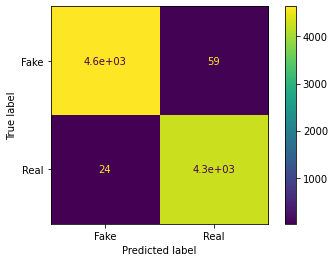



 > Naive Bayes using TF-IDF
 Accuracy: 96.75%
 F1 Score: 96.58%


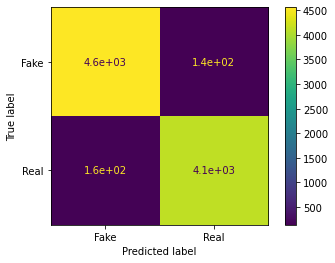



 > Naive Bayes using Word2Vec
 Accuracy: 96.53%
 F1 Score: 96.39%


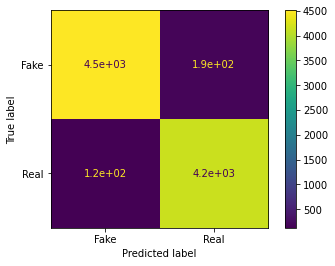

In [35]:
# Given the train and test data/labels, it calculates and prints the accuracy and f1 score of a Naive Bayes model 
def naiveBayesClassification(traindata, trainlabel, testdata, testlabel):
  # Create a naive Bayes classification model
  model = MultinomialNB( alpha=0.0005, fit_prior=False )

  # Fit the train data to it
  model.fit(traindata, trainlabel)

  # Make a prediction
  prediction = model.predict(testdata)
  # Get the true/false positive/negative results using a confusion matrix
  tn, fp, fn, tp = confusion_matrix(testlabel, prediction).ravel()
  # Get a full acurracy report
  if (analStats == 1):
    print( classification_report(testlabel.to_frame(),prediction) )

  # Calculate and Print the scores (Use true/false positive/negative to calculate the f1 score)
  print(' Accuracy: %.2f%%' % (accuracy_score(testlabel, prediction)*100) )
  print(' F1 Score: %.2f%%' % ( (tp/(tp+(fp+fn)/2))*100) )

  # Finally, plot the comfusion matrix for a better visualization
  plot_confusion_matrix(model, testdata, testlabel, display_labels=['Fake', 'Real', 'Fake', 'Real'])  
  plt.show()  
  print('\n')


print(" > Naive Bayes using BoW")
naiveBayesClassification(traindata_bow, trainlabel, testdata_bow, testlabel)
print(" > Naive Bayes using TF-IDF")
naiveBayesClassification(traindata_tfidf, trainlabel, testdata_tfidf, testlabel)
print(" > Naive Bayes using Word2Vec")
naiveBayesClassification(traindata_w2v, trainlabel, testdata_w2v, testlabel)